# 머신러닝 모델 기반 다른 유저들의 승률 예측 분석

<목차>

1. 개요

2. EDA

3. Feature Engineering

4. 모델 개발

5. 모델 평가

---
---

## 개요

### 1. 목적
- 승리 예측 모델 개발 및 특성 중요도 분석
    - 승리에 주요하게 영향을 미치는 특성을 파악하기 위함

### 2. 데이터 설명
- FC온라인 API를 통해 수집한 다른 유저들의 경기 데이터
- 득점한 선수에 관련한 데이터는 분석에 활용하지 않고, 유저의 플레이 데이터만 활용한다.
- 매치ID 중복 데이터 존재 > 경기 기준이 아닌 골 기준으로 ROW가 집계됨(득점 좌표 데이터 활용하기 위함)
- API를 통해 호출한 데이터를 가공하여 다운 받은 CSV 파일을 호출한다.

### 3. 분석 환경 조성

#### ㄴ 라이브러리 호출

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import plotly.express as px
from sklearn.neighbors import NearestNeighbors


from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

#### ㄴ 데이터 호출

In [4]:
# 데이터 프레임 생성
#match_df_1 = pd.read_csv('data/250321_recent_matches.csv', encoding='utf-8-sig')
#match_df_2 = pd.read_csv('data/250323_recent_matches.csv', encoding='utf-8-sig')
match_df_3 = pd.read_csv('data/250324_recent_matches.csv', encoding='utf-8-sig')
match_df_4 = pd.read_csv('data/250325_recent_matches.csv', encoding='utf-8-sig')

In [5]:
# 각 데이터 프레임 크기 확인
#print(match_df_1.shape) # 3/21기준 최근 100경기 데이터
#print(match_df_2.shape) # 3/23기준 최근 100경기 데이터
print(match_df_3.shape) # 3/24기준 최근 100경기 데이터
print(match_df_4.shape) # 3/25기준 최근 100경기 데이터

(86, 43)
(738, 43)


In [ ]:
# 데이터 프레임 확인
match_df_1.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67e13ae44065376a668ffd79,2025-03-24T10:59:34,50,c69d1fc3d30168bae289e407f866e913,DRX엄지렐라,패,2,0,0,0,...,127,0.950309,0.483909,6,1,291206594,False,-1,False,True
1,67e13aa29ed34d74ce8f1afa,2025-03-24T10:59:57,50,a4c86fd92dbadafe4acef48dc03579ea,소각영도점,패,2,0,0,0,...,425,0.880318,0.622680,2,2,265216409,False,-1,False,True
2,67e13a8aa1826dbfeede1857,2025-03-24T10:58:33,50,c1985d83d9eaf2451042c6d93e566b14,너없이는못살아,승,1,0,0,0,...,490,0.827593,0.522800,2,3,289049072,True,814166149,False,False
3,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,575,0.941004,0.672179,1,3,829231447,True,252214100,False,True
4,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,154,0.890730,0.583691,2,3,268192181,True,252214100,False,True


In [4]:
# 데이터 프레임 확인
match_df_2.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,possession,averageRating,dribble,cornerKick,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67dfdb2cffc7b2223341cf28,2025-03-23T09:59:42,50,11e680208c9d26a251023337fcf4e870,망고욱현,승,62,4.38333,4,0,...,232,0.906021,0.670537,2,3,291240452,True,829227232,False,True
1,67dfdb1a8a1ee8788f3e6130,2025-03-23T09:59:03,50,5403c8a5423a2c08696f68a32bc816c6,찌랭이0327,승,44,3.98889,5,1,...,573,0.839968,0.387843,2,3,832256630,True,291240709,False,False
2,67dfdb17e795d740a68bdf08,2025-03-23T09:59:50,50,7e09a42b042a3ca88ba0d8214c61fc79,구단주댄스바,패,48,3.49444,7,1,...,475,0.783291,0.395553,4,2,826225539,False,-1,False,False
3,67dfdb17e795d740a68bdf08,2025-03-23T09:59:50,50,7e09a42b042a3ca88ba0d8214c61fc79,구단주댄스바,패,48,3.49444,7,1,...,135,0.908727,0.547382,1,1,826225539,True,270243702,False,True
4,67dfdaea8f28057e623fbaf9,2025-03-23T09:58:53,50,62ce1ea7553b9306f327702dfeaa0ba9,JEON영진,패,60,3.71111,10,0,...,490,0.928970,0.413836,6,1,832194765,True,825028130,False,True


In [7]:
# 데이터 프레임 확인
match_df_3.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67e13ae44065376a668ffd79,2025-03-24T10:59:34,50,c69d1fc3d30168bae289e407f866e913,DRX엄지렐라,패,2,0,0,0,...,127,0.950309,0.483909,6,1,291206594,False,-1,False,True
1,67e13aa29ed34d74ce8f1afa,2025-03-24T10:59:57,50,a4c86fd92dbadafe4acef48dc03579ea,소각영도점,패,2,0,0,0,...,425,0.880318,0.622680,2,2,265216409,False,-1,False,True
2,67e13a8aa1826dbfeede1857,2025-03-24T10:58:33,50,c1985d83d9eaf2451042c6d93e566b14,너없이는못살아,승,1,0,0,0,...,490,0.827593,0.522800,2,3,289049072,True,814166149,False,False
3,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,575,0.941004,0.672179,1,3,829231447,True,252214100,False,True
4,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,154,0.890730,0.583691,2,3,268192181,True,252214100,False,True


In [6]:
# 데이터 프레임 확인
match_df_4.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67e1f18d273fbc4a46b37f9b,2025-03-24T23:59:37,50,55c2061645c1492e95e62eed782af8f8,나이기면축잘알,승,1,0,0,0,...,182,0.788435,0.329238,1,3,820239085,True,825231866,False,False
1,67e1f1017f5021c485400a6f,2025-03-24T23:58:01,50,87646786082028345ae3ccb7d3f08f50,LaCintura,승,1,0,0,0,...,210,0.895556,0.502413,1,3,820020801,True,828231747,False,True
2,67e1f1017f5021c485400a6f,2025-03-24T23:58:01,50,87646786082028345ae3ccb7d3f08f50,LaCintura,승,1,0,0,0,...,660,0.933971,0.530024,3,2,825165153,False,-1,False,True
3,67e1f1017f5021c485400a6f,2025-03-24T23:58:01,50,87646786082028345ae3ccb7d3f08f50,LaCintura,승,1,0,0,0,...,831,0.881881,0.508044,1,3,810252371,True,828231747,False,True
4,67e1f1017f5021c485400a6f,2025-03-24T23:58:01,50,87646786082028345ae3ccb7d3f08f50,LaCintura,승,1,0,0,0,...,603,0.875750,0.598381,1,1,820020801,False,-1,False,True


- 데이터 프레임 병합
    - 각 날짜에 최근 100경기를 API로 호출했으나 몇 경기에서 error 코드가 발생해 집계가 되지 않는 문제 발생
    - 최대한 많은 모수 확보를 위해 해당 데이터 제외하고 나머지 데이터들 호출

In [8]:
# 데이터 병합
# match_df = pd.concat([match_df_1,match_df_2,match_df_3], axis=0, ignore_index=True)
match_df = pd.concat([match_df_3,match_df_4], axis=0, ignore_index=True)
match_df.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67e13ae44065376a668ffd79,2025-03-24T10:59:34,50,c69d1fc3d30168bae289e407f866e913,DRX엄지렐라,패,2,0,0,0,...,127,0.950309,0.483909,6,1,291206594,False,-1,False,True
1,67e13aa29ed34d74ce8f1afa,2025-03-24T10:59:57,50,a4c86fd92dbadafe4acef48dc03579ea,소각영도점,패,2,0,0,0,...,425,0.880318,0.622680,2,2,265216409,False,-1,False,True
2,67e13a8aa1826dbfeede1857,2025-03-24T10:58:33,50,c1985d83d9eaf2451042c6d93e566b14,너없이는못살아,승,1,0,0,0,...,490,0.827593,0.522800,2,3,289049072,True,814166149,False,False
3,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,575,0.941004,0.672179,1,3,829231447,True,252214100,False,True
4,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,154,0.890730,0.583691,2,3,268192181,True,252214100,False,True


---

## EDA

### 1. 데이터 확인

In [9]:
# 데이터 크기 확인
match_df.shape

(824, 43)

In [10]:
# 기술 통계 분석
match_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
matchId,824,92,67e1f07f3555a4c1c62a54af,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchDate,824,79,2025-03-24T23:59:57,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchType,824.0,NaN,NaN,NaN,50.0,0.0,50.0,50.0,50.0,50.0,50.0
ouid,824,139,04f8cc1758dcf229553c7c4f932b410c,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nickname,824,139,게임일뿐즐겨라,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchResult,824,3,승,508,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchEndType,824.0,NaN,NaN,NaN,0.552184,0.631067,0.0,0.0,0.0,1.0,2.0
foul,824.0,NaN,NaN,NaN,0.293689,0.511029,0.0,0.0,0.0,1.0,2.0
injury,824.0,NaN,NaN,NaN,0.084951,0.278979,0.0,0.0,0.0,0.0,1.0
redCards,824.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# 데이터 정보 확인
match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   matchId              824 non-null    object 
 1   matchDate            824 non-null    object 
 2   matchType            824 non-null    int64  
 3   ouid                 824 non-null    object 
 4   nickname             824 non-null    object 
 5   matchResult          824 non-null    object 
 6   matchEndType         824 non-null    int64  
 7   foul                 824 non-null    int64  
 8   injury               824 non-null    int64  
 9   redCards             824 non-null    int64  
 10  yellowCards          824 non-null    int64  
 11  possession           824 non-null    int64  
 12  averageRating        824 non-null    float64
 13  dribble              824 non-null    int64  
 14  cornerKick           824 non-null    int64  
 15  offsideCount         824 non-null    int

#### ㄴ 데이터 분포 시각화

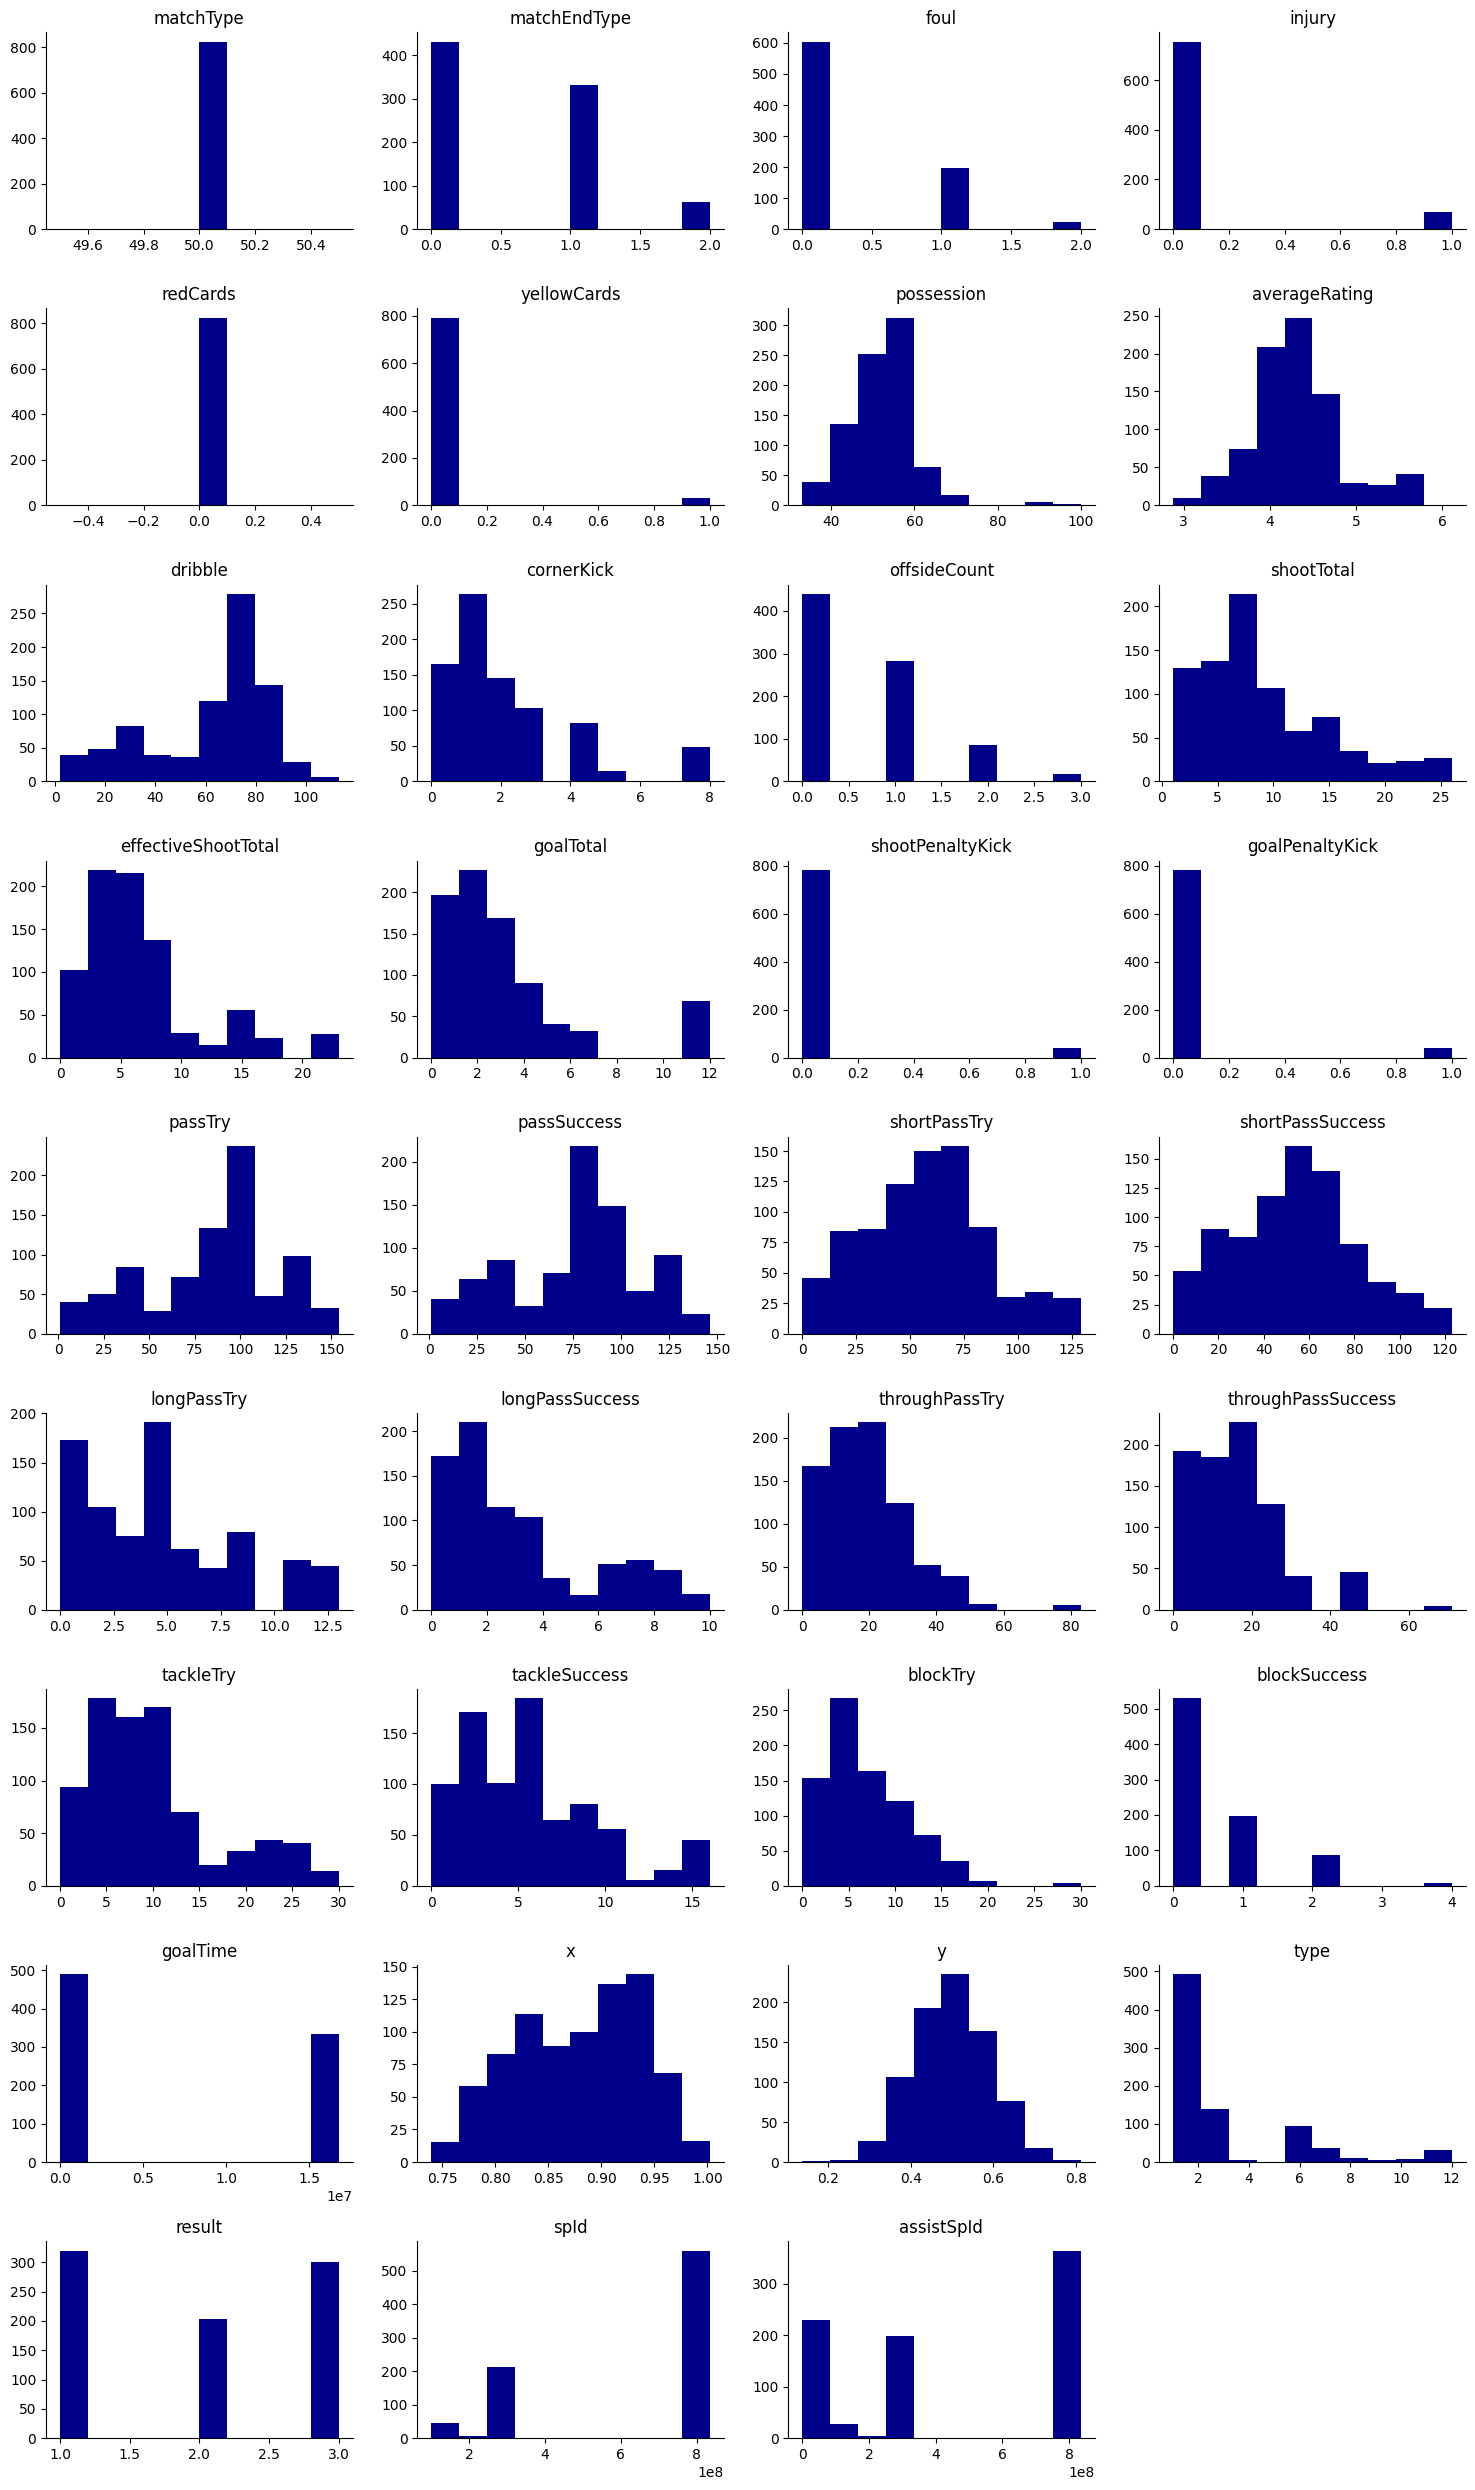

In [12]:
# 데이터 분포 시각화
# 변수 선별
numeric_df = match_df.select_dtypes(include=['number'])
cols = numeric_df.columns

# 서브플롯 생성
fig, axes = plt.subplots(9, 4, figsize=(15, 25))
axes = axes.flatten()

# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    axes[i].hist(numeric_df[column].dropna(), color='darkblue', alpha=1)
    axes[i].set_title(column)
    axes[i].grid(axis='x', linestyle=':', color='darkgrey')
    axes[i].grid(axis='x')
    axes[i].spines[['top','right']].set_visible(False)

# 빈 서브플롯 숨기기
for j in range(len(cols), len(axes)):
    axes[j].axis("off")

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

> 결론
- spId, assistSpId는 선수 고유 ID
- goalTime의 max값이 3분위수와 차이가 많이 난다.
- 연속형 변수 중, goalTime을 제외하고는 특별한 이상치가 기술 통계량에서는 확인되지 않는다.
- matchResult는 승리 여부로, 범주형 변수이자 머신러닝 모델의 종속변수가 된다.(이진수가 아닌 '승','패'로 object 타입으로 저장되어 있다.)
- Try와 Success 데이터를 통해 성공확률을 도출할 수 있다.(ex. 패스, 숏패스, 롱패스, 스루패스, 태클 등)

### 2. 데이터 전처리

#### ㄴ 결측값 처리

In [13]:
# 결측값 확인
match_df.isna().sum()

matchId                0
matchDate              0
matchType              0
ouid                   0
nickname               0
matchResult            0
matchEndType           0
foul                   0
injury                 0
redCards               0
yellowCards            0
possession             0
averageRating          0
dribble                0
cornerKick             0
offsideCount           0
shootTotal             0
effectiveShootTotal    0
goalTotal              0
shootPenaltyKick       0
goalPenaltyKick        0
passTry                0
passSuccess            0
shortPassTry           0
shortPassSuccess       0
longPassTry            0
longPassSuccess        0
throughPassTry         0
throughPassSuccess     0
tackleTry              0
tackleSuccess          0
blockTry               0
blockSuccess           0
goalTime               0
x                      0
y                      0
type                   0
result                 0
spId                   0
assist                 0


#### ㄴ 중복값 처리

- 데이터는 골 기준으로 ROW가 생성되고 있다.
- 한 경기에 여러 골이 발생하므로 matchId는 중복값 발생
- 따라서 식별자로 사용할 수 없으므로 모든 행에 대해서 중복값이 있는지 체크한다.

In [14]:
# 중복값 확인
match_df.duplicated().sum()

np.int64(0)

- 득점과 관련된 데이터(득점 슛 위치 좌표, 슛 유형, 득점 시간, 득점 선수, 어시스트 선수)는 모델 생성에 활용하지 않고, 따로 세부 분석을 통해 인사이트를 도출하기로 한다.
    - ROW를 경기 단위로 생성하기 위함

In [33]:
# 데이터 누수 방지를 위해 데이터 프레임 복제
preprocessed_df = match_df.copy()

# 득점과 관련된 변수 및 'ouid' 삭제
preprocessed_df = preprocessed_df.drop(columns=['goalTime', 'x', 'y', 'type','result', 'spId', 'assist', 'assistSpId', 'hitPost', 'inPenalty'])

In [34]:
# 변수 삭제 확인
preprocessed_df.columns

Index(['matchId', 'matchDate', 'matchType', 'ouid', 'nickname', 'matchResult',
       'matchEndType', 'foul', 'injury', 'redCards', 'yellowCards',
       'possession', 'averageRating', 'dribble', 'cornerKick', 'offsideCount',
       'shootTotal', 'effectiveShootTotal', 'goalTotal', 'shootPenaltyKick',
       'goalPenaltyKick', 'passTry', 'passSuccess', 'shortPassTry',
       'shortPassSuccess', 'longPassTry', 'longPassSuccess', 'throughPassTry',
       'throughPassSuccess', 'tackleTry', 'tackleSuccess', 'blockTry',
       'blockSuccess'],
      dtype='object')

- matchId로 그룹핑하여 새로운 데이터 테이블 생성
    - 'ouid', 'nickname' 삭제 : 분석에 미활용
    - matchId당 하나의 값을 가지는 데이터들 : 'matchDate', 'matchType', 'matchResult', 'matchEndType'
    - 그룹핑해서 합계 산출해야 하는 데이터들 : 
       'foul', 'injury', 'redCards', 'yellowCards','dribble', 'cornerKick', 'offsideCount',
       'shootTotal', 'effectiveShootTotal', 'goalTotal', 'shootPenaltyKick',
       'goalPenaltyKick', 'passTry', 'passSuccess', 'shortPassTry',
       'shortPassSuccess', 'longPassTry', 'longPassSuccess', 'throughPassTry',
       'throughPassSuccess', 'tackleTry', 'tackleSuccess', 'blockTry', 'blockSuccess'
    - 그룹핑해서 평균 산출해야 하는 데이터들 : 'possession', 'averageRating'

In [ ]:
match_group_df = preprocessed_df

#### ㄴ 이상치 처리

In [22]:
# 몰수승, 몰수패는 정상적으로 종료되지 않은 매치이므로 제외한다.('matchEndType' == 0인 경우가 정상)
preprocessed_df = match_df.copy()
print(preprocessed_df['matchEndType'].unique())
preprocessed_df['matchEndType'].value_counts()

[2 1 0]


matchEndType
0    431
1    331
2     62
Name: count, dtype: int64

In [23]:
# 정상종료 매치만 남기기
preprocessed_df = preprocessed_df[preprocessed_df['matchEndType'] == 0]

In [24]:
# 수치형 변수 확인
numeric_df.columns

Index(['matchType', 'matchEndType', 'foul', 'injury', 'redCards',
       'yellowCards', 'possession', 'averageRating', 'dribble', 'cornerKick',
       'offsideCount', 'shootTotal', 'effectiveShootTotal', 'goalTotal',
       'shootPenaltyKick', 'goalPenaltyKick', 'passTry', 'passSuccess',
       'shortPassTry', 'shortPassSuccess', 'longPassTry', 'longPassSuccess',
       'throughPassTry', 'throughPassSuccess', 'tackleTry', 'tackleSuccess',
       'blockTry', 'blockSuccess', 'goalTime', 'x', 'y', 'type', 'result',
       'spId', 'assistSpId'],
      dtype='object')

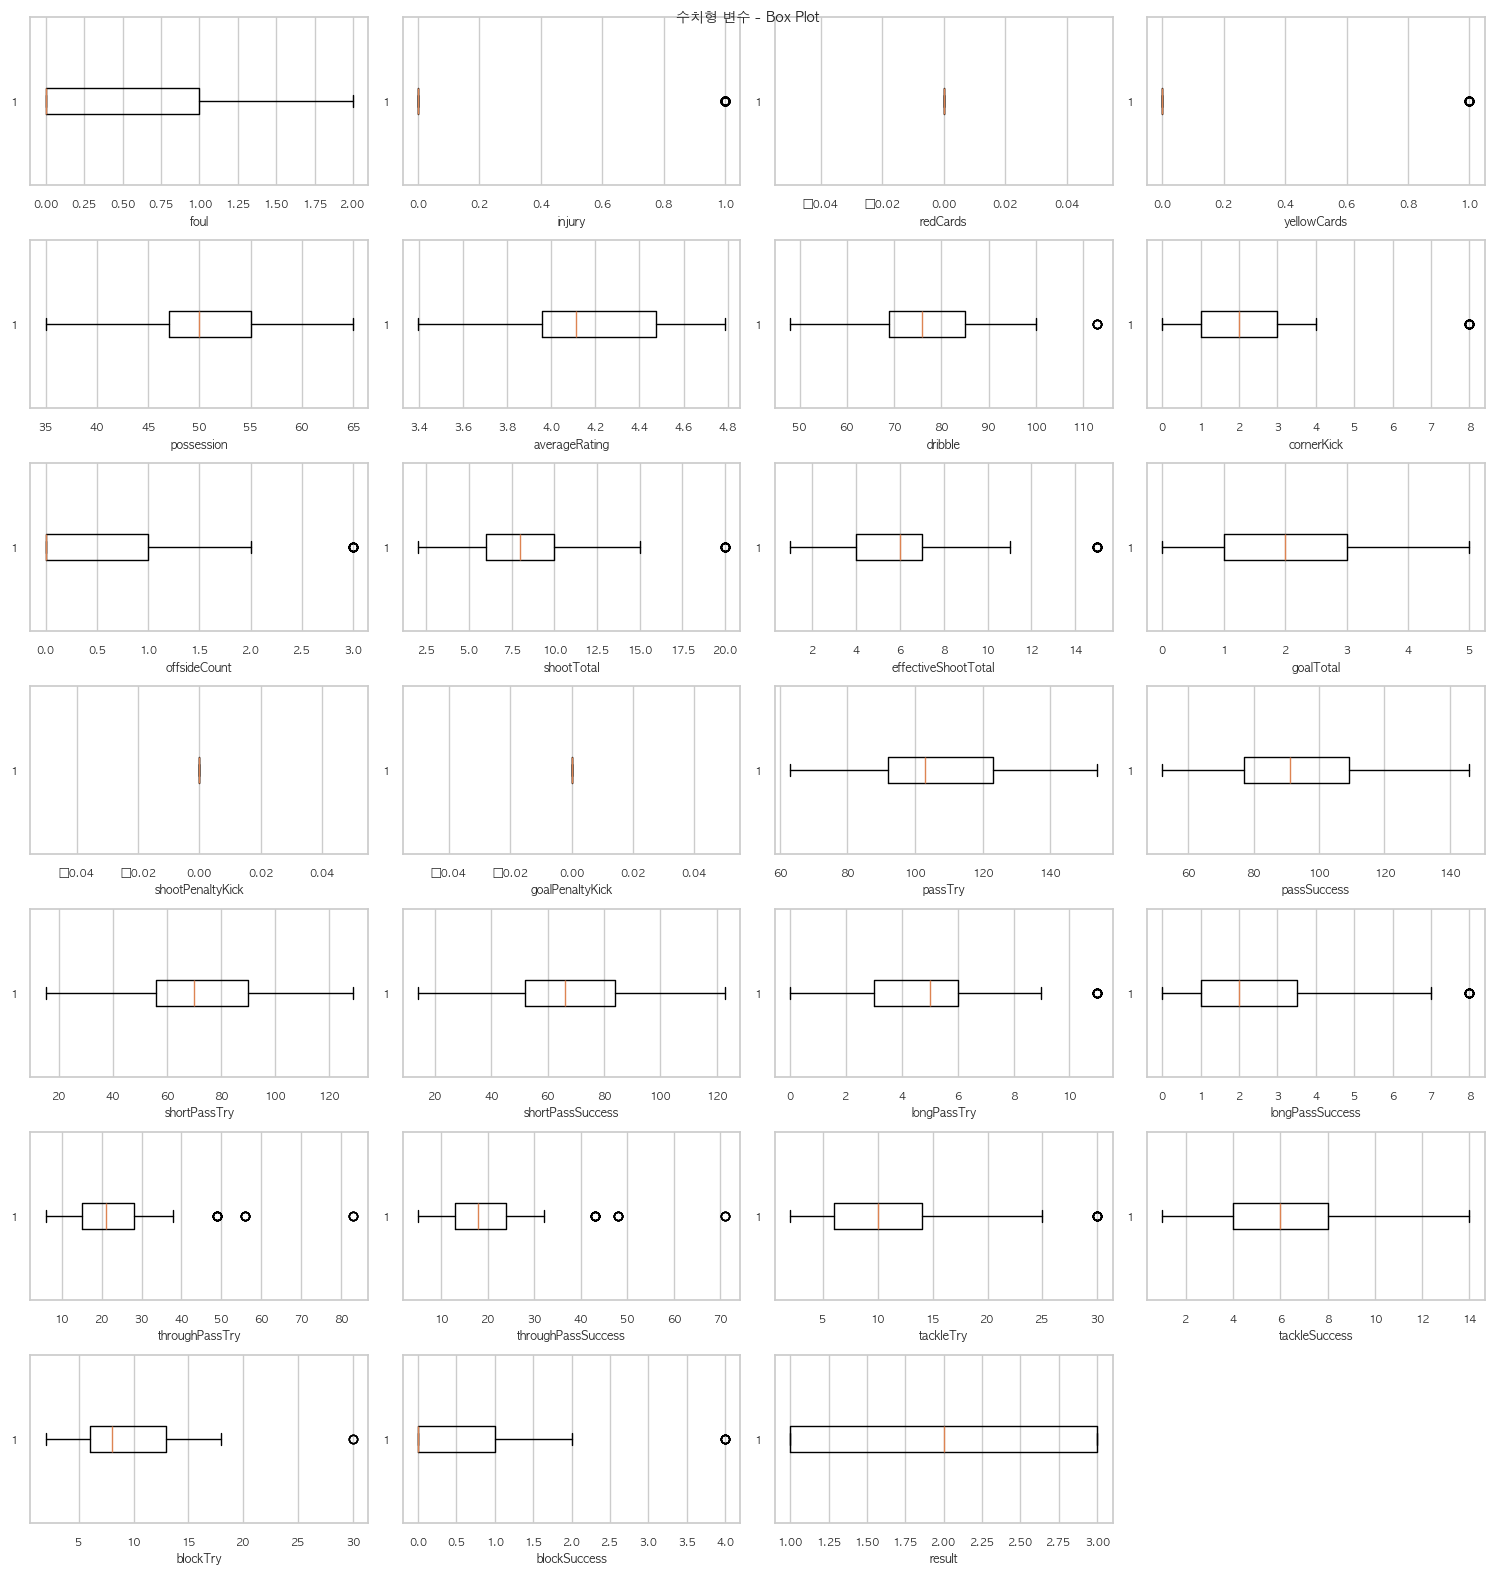

In [25]:
# 이상치 확인할 변수 선택
outlier_cols = list(numeric_df.drop(columns=['matchType', 'matchEndType','goalTime','x', 'y', 'type','spId', 'assistSpId']).columns)

# 컬럼별 이상치 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(10,6)}, font_scale=0.7, font='AppleGothic')

fig, axes = plt.subplots(7,4,figsize=(15, 16))
axes = axes.flatten()

for i, col in enumerate(outlier_cols):
    axes[i].boxplot(preprocessed_df[col],  vert=False)
    axes[i].set_xlabel(f'{col}')
    axes[i].set_xlabel(f'{col}')
    axes[i].grid(axis='y')

# 빈 서브플롯 숨기기
for j in range(len(outlier_cols), len(axes)):
    axes[j].axis("off")

fig.suptitle('수치형 변수 - Box Plot')

fig.tight_layout()
fig.show()

In [19]:
# 이상치 개수 확인
for col in outlier_cols:
  q1 = preprocessed_df[col].quantile(0.25)
  q3 = preprocessed_df[col].quantile(0.75)
  iqr = q3-q1
  outlier_count = len(preprocessed_df[(preprocessed_df[col] < (q1 - (1.5*iqr)))|(preprocessed_df[col] > (q3 + (1.5*iqr)))])

  print(f"{col} - 이상치 개수: {outlier_count}", '/', f"비율: {round((outlier_count/len(preprocessed_df))*100,2)}%")

foul - 이상치 개수: 0 / 비율: 0.0%
injury - 이상치 개수: 62 / 비율: 14.39%
redCards - 이상치 개수: 0 / 비율: 0.0%
yellowCards - 이상치 개수: 32 / 비율: 7.42%
possession - 이상치 개수: 0 / 비율: 0.0%
averageRating - 이상치 개수: 0 / 비율: 0.0%
dribble - 이상치 개수: 7 / 비율: 1.62%
cornerKick - 이상치 개수: 21 / 비율: 4.87%
offsideCount - 이상치 개수: 17 / 비율: 3.94%
shootTotal - 이상치 개수: 21 / 비율: 4.87%
effectiveShootTotal - 이상치 개수: 21 / 비율: 4.87%
goalTotal - 이상치 개수: 0 / 비율: 0.0%
shootPenaltyKick - 이상치 개수: 0 / 비율: 0.0%
goalPenaltyKick - 이상치 개수: 0 / 비율: 0.0%
passTry - 이상치 개수: 0 / 비율: 0.0%
passSuccess - 이상치 개수: 0 / 비율: 0.0%
shortPassTry - 이상치 개수: 0 / 비율: 0.0%
shortPassSuccess - 이상치 개수: 0 / 비율: 0.0%
longPassTry - 이상치 개수: 17 / 비율: 3.94%
longPassSuccess - 이상치 개수: 18 / 비율: 4.18%
throughPassTry - 이상치 개수: 24 / 비율: 5.57%
throughPassSuccess - 이상치 개수: 24 / 비율: 5.57%
tackleTry - 이상치 개수: 14 / 비율: 3.25%
tackleSuccess - 이상치 개수: 0 / 비율: 0.0%
blockTry - 이상치 개수: 4 / 비율: 0.93%
blockSuccess - 이상치 개수: 9 / 비율: 2.09%
result - 이상치 개수: 0 / 비율: 0.0%


> 결론

- injury : 부상 수, 부상은 인게임에서 잘 발생하지 않아 대부분의 데이터가 0에 몰려 있어 사분위수로 이상치 탐지시 1과 같은 정상값도 이상치로 간주됨.(이상치 처리 X)
- foul : 파울 수, 대부분의 데이터가 0에 몰려 있어 사분위수로 이상치 탐지시 1, 2와 같은 정상값도 이상치로 간주됨.(이상치 처리 X)
- possession : 점유율이 100%인 경우는 존재할 수 없으므로 이상치로 간주하여 처리한다.
- averageRating : 경기 사후에 매겨지는 경기 평점이므로 경기 결과에 영향을 주지 않는다. 이상치 처리 필요성 X
- shootTotal : 총 슈팅 수가 1인 경기 또한 공격이 제대로 진행되지 않은 경기로써, 분석할 가치가 있으므로 이상치 처리 X
- shootPenaltyKick : 대부분의 경기에서 페널티킥이 발생하지 않으므로 1이 이상치로 관찰되는 것이며, 실질적인 이상치는 아니다.
- goalPenaltyKick : 위와 동일
- 슛, 패스, 태클, 블록 시도 및 성공 : 5% 내외의 이상치 발생, `KNN알고리즘으로 이웃 평균치로 대치`

- KNN 활용 이상치 처리

In [ ]:
try_success_cols = ['longPassTry', 'longPassSuccess' ,'throughPassTry','throughPassSuccess','tackleTry','blockTry','blockSuccess']

# 데이터 누수 방지를 위해 데이터프레임 복제
outlier_processed_df = preprocessed_df.copy()

# KNN 모델을 사용하여 이웃 계산
knn = NearestNeighbors(n_neighbors=5)  # n_neighbors 값을 직접 설정

# 데이터로 학습
knn.fit(outlier_processed_df[try_success_cols])

# 각 샘플에 대해 가장 가까운 이웃까지의 거리 계산
distances, indices = knn.kneighbors(outlier_processed_df[try_success_cols])

# distance_threshold 값을 결정하는 방법 (상위 90% 거리값 기준)
distance_threshold = np.percentile(distances[:, -1], 90)

# 이상치 판별
outliers = distances[:, -1] > distance_threshold

# 이상치 대치 (예: 가까운 이웃의 평균값으로 대체)
for i in range(outlier_processed_df[try_success_cols].shape[0]):
    if outliers[i]:
        # 이상치인 경우, 해당 샘플의 이웃들의 평균값으로 대체
        outlier_processed_df[try_success_cols].iloc[i] = np.mean(outlier_processed_df[try_success_cols].iloc[indices[i]], axis=0)

# 결과 출력
print(f"감지된 이상치 개수: {sum(outliers)}")

#### ㄴ 데이터 인코딩

In [ ]:
# 범주형 데이터 확인 - 기술통계량
preprocessed_df.describe(include='all')

In [ ]:
# 범주형 데이터 확인 - 데이터 타입(category)
preprocessed_df.select_dtypes('category')

### 3. 상관관계 분석